In [1]:
#pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

C:\Users\USER\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Dataset path
DATA_DIR = "./recycling_waste"

# Parameters
batch_size = 32
img_height = 180
img_width = 180
seed = 123

In [3]:
import os

valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
DATA_DIR = "./recycling_waste"

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if not file.lower().endswith(valid_ext):
            print(f"Removing unsupported file: {os.path.join(root, file)}")
            os.remove(os.path.join(root, file))


In [4]:
from PIL import Image

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith(valid_ext):
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()  # Check integrity
            except Exception as e:
                print(f"Corrupted image removed: {img_path}")
                os.remove(img_path)


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,   # 20% for validation
    subset="training",
    seed=123,               # ensure same split each time
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 8344 files belonging to 9 classes.
Using 6676 files for training.
Found 8344 files belonging to 9 classes.
Using 1668 files for validation.


In [6]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['batteries', 'clothes', 'e-waste', 'glass', 'light blubs', 'metal', 'organic', 'paper', 'plastic']


In [7]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

layered pipeline of random image changes that helps model generalize better by seeing slightly altered versions of training images each time without needing more data.

In [10]:
# Apply augmentation only on training data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
normalized_train_ds = augmented_train_ds.map(lambda x, y: (normalization_layer(x), y))


In [11]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Number of classes: 9

 Number of images per class:
batteries: 1118 images
clothes: 722 images
e-waste: 664 images
glass: 766 images
light blubs: 632 images
metal: 1081 images
organic: 673 images
paper: 1450 images
plastic: 1238 images

 Range of images per class: 632 - 1450


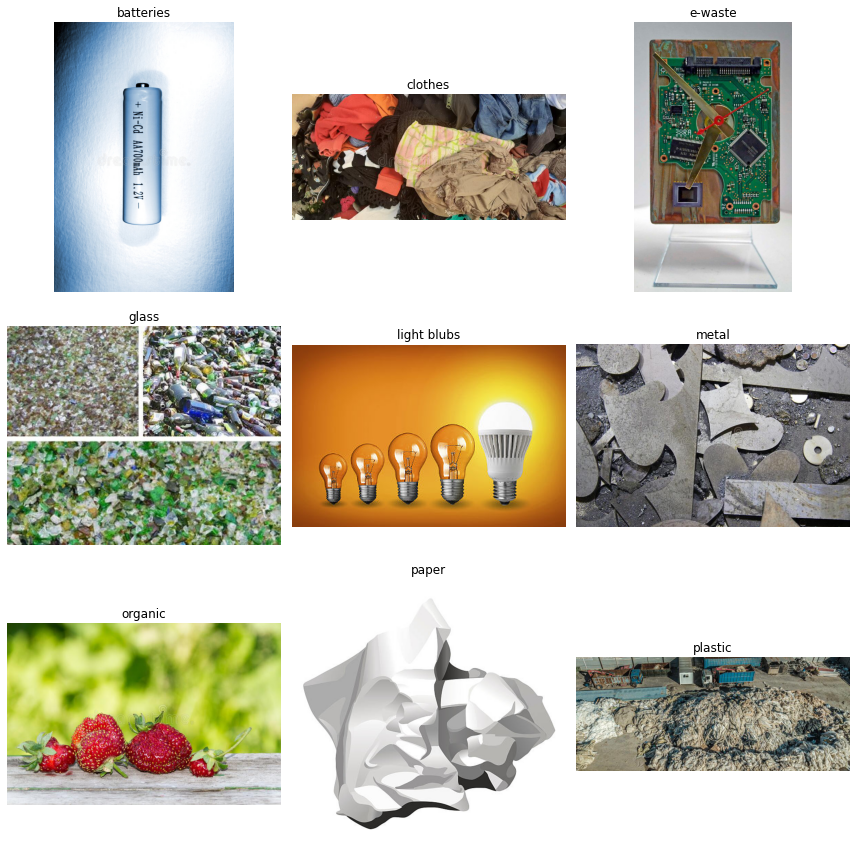

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Dataset path
DATA_DIR = "./recycling_waste"

# List class names (folder names)
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Number of classes: {len(class_names)}")

# Count number of images per class
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(DATA_DIR, class_name)
    # Only count image files
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    class_counts[class_name] = len(files)

print("\n Number of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

print(f"\n Range of images per class: {min(class_counts.values())} - {max(class_counts.values())}")

# Plot 1 sample image per class
plt.figure(figsize=(12, 12))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_DIR, class_name)
    sample_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    if not sample_images:
        continue  # Skip if folder is empty or no valid images

    img_path = os.path.join(class_path, sample_images[0])
    img = Image.open(img_path)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# CNN Architectures

## Simple CNN

In [14]:
from tensorflow.keras import layers, models

# Define the simple CNN model
def build_simple_cnn():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        # First Conv block
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        # Second Conv block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(9, activation='softmax') 
    ])
    return model


In [15]:
from tensorflow.keras import layers, models

def build_deeper_cnn():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(9, activation='softmax')
    ])
    return model

    

In [16]:
# Build models
simple_cnn = build_simple_cnn()
deeper_cnn = build_deeper_cnn()

In [17]:
models_dict = {
    "Simple CNN": simple_cnn,
    "Deeper CNN (3 Blocks)": deeper_cnn
}

# Print summaries and layer shapes — no image plots
for name, model in models_dict.items():
    print(f"\n{name} summary:")
    model.summary()
    print(f"\n{name} layers and output shapes:")
    for layer in model.layers:
        print(f"  - {layer.name}: {layer.output_shape}")
    print("\n ++++++++++++++++++ ++++++++++++++++++\n")


Simple CNN summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (Non


Simple CNN summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (Non

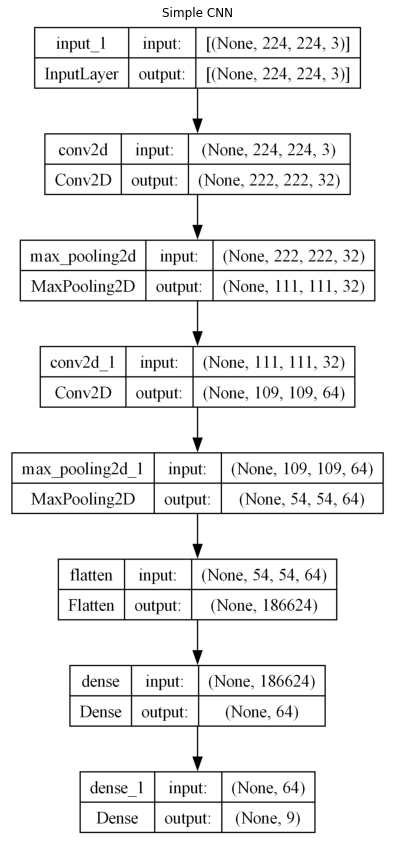


 ++++++++++++++++++ ++++++++++++++++++


Deeper CNN summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      369

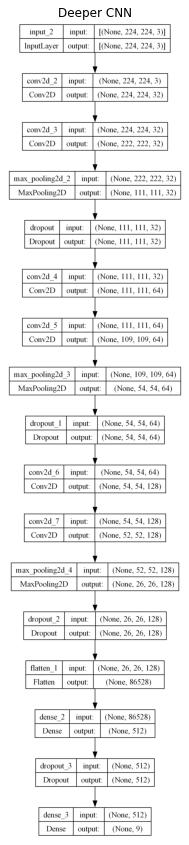


 ++++++++++++++++++ ++++++++++++++++++



In [20]:
import tempfile
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Store in dictionary
models_dict = {
    "Simple CNN": simple_cnn,
    "Deeper CNN": deeper_cnn
}

# Plot and summarize
for name, model in models_dict.items():
    print(f"\n{name} summary:")
    model.summary()
    
    # Plot model architecture
    plot_file = tempfile.mktemp(suffix='.png')
    tf.keras.utils.plot_model(model, to_file=plot_file, show_shapes=True, dpi=300)
    
    # Show the plot
    img = plt.imread(plot_file)
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.title(name)
    plt.show()
    
    print("\n ++++++++++++++++++ ++++++++++++++++++\n")

In [21]:
EPOCHS = 10
histories = {}

for name, model in models_dict.items():
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f"\nTraining {name}...")
    history = model.fit(
        normalized_train_ds,
        validation_data=normalized_val_ds,
        epochs=EPOCHS,
        verbose=2
    )
    
    histories[name] = history



Training Simple CNN...
Epoch 1/10
209/209 - 228s - loss: 2.3880 - accuracy: 0.2176 - val_loss: 1.9807 - val_accuracy: 0.2926 - 228s/epoch - 1s/step
Epoch 2/10
209/209 - 231s - loss: 1.9322 - accuracy: 0.3038 - val_loss: 1.8763 - val_accuracy: 0.3094 - 231s/epoch - 1s/step
Epoch 3/10
209/209 - 239s - loss: 1.8325 - accuracy: 0.3420 - val_loss: 1.9015 - val_accuracy: 0.3094 - 239s/epoch - 1s/step
Epoch 4/10
209/209 - 228s - loss: 1.7677 - accuracy: 0.3602 - val_loss: 1.8401 - val_accuracy: 0.3507 - 228s/epoch - 1s/step
Epoch 5/10
209/209 - 218s - loss: 1.7144 - accuracy: 0.3904 - val_loss: 1.8239 - val_accuracy: 0.3507 - 218s/epoch - 1s/step
Epoch 6/10
209/209 - 215s - loss: 1.6794 - accuracy: 0.3941 - val_loss: 1.7710 - val_accuracy: 0.3873 - 215s/epoch - 1s/step
Epoch 7/10
209/209 - 228s - loss: 1.6424 - accuracy: 0.4133 - val_loss: 1.7064 - val_accuracy: 0.3741 - 228s/epoch - 1s/step
Epoch 8/10
209/209 - 215s - loss: 1.5747 - accuracy: 0.4384 - val_loss: 1.6426 - val_accuracy: 0.4323

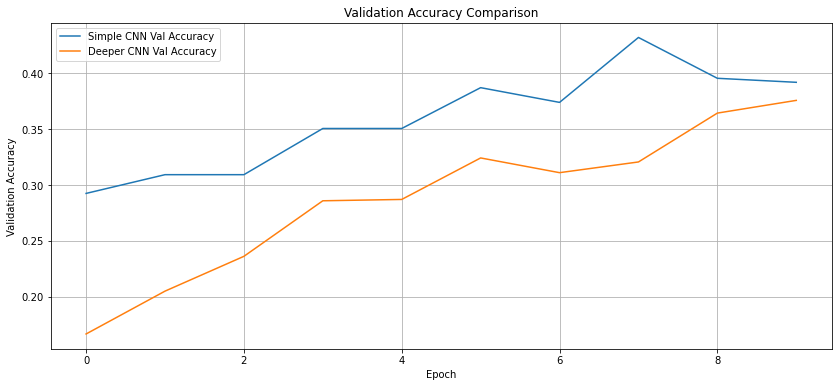

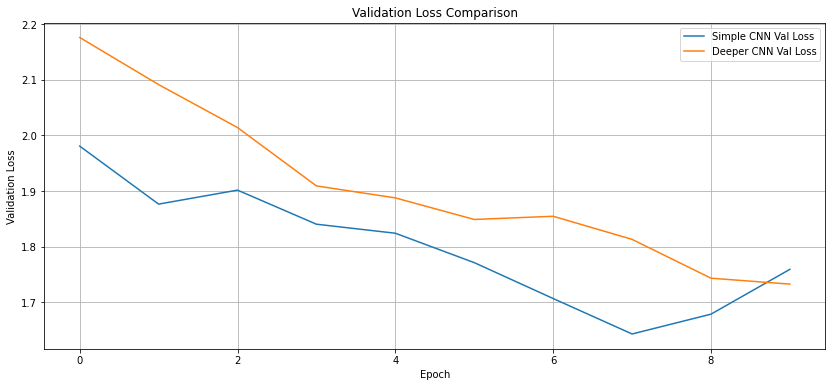

In [22]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy for all models
plt.figure(figsize=(14, 6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Loss for all models
plt.figure(figsize=(14, 6))
for name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Save
simple_cnn.save('simple_cnn_saved_model')
deeper_cnn.save('deeper_cnn_saved_model')

# Load
loaded_simple_cnn = tf.keras.models.load_model('simple_cnn_saved_model')
loaded_deeper_cnn = tf.keras.models.load_model('deeper_cnn_saved_model')


INFO:tensorflow:Assets written to: simple_cnn_saved_model\assets


INFO:tensorflow:Assets written to: simple_cnn_saved_model\assets


INFO:tensorflow:Assets written to: deeper_cnn_saved_model\assets


INFO:tensorflow:Assets written to: deeper_cnn_saved_model\assets


In [43]:
# Predict on entire validation dataset (batches)
predictions = loaded_simple_cnn.predict(normalized_val_ds) 

# predictions shape: (num_samples, num_classes)
print(predictions.shape)


53/53 [==============================] - 9s 174ms/step
(1668, 9)


In [42]:
# Predict on entire validation dataset (batches)
predictions1 = loaded_deeper_cnn.predict(normalized_val_ds) 

# predictions shape: (num_samples, num_classes)
print(predictions.shape)

53/53 [==============================] - 28s 529ms/step
(1668, 9)


In [46]:
#Convert predictions to class indices
import numpy as np
predicted_class_indices = np.argmax(predictions, axis=1)
print(predicted_class_indices)


[6 2 2 ... 8 1 1]


In [47]:
predicted_class_indices1= np.argmax(predictions1, axis=1)
print(predicted_class_indices1)

[0 7 2 ... 8 1 8]


In [26]:
#Map indices to class names
class_names = ['batteries', 'clothes', 'e-waste', 'glass', 'light blubs', 'metal', 'organic', 'paper', 'plastic']

predicted_class_names = [class_names[i] for i in predicted_class_indices]
print(predicted_class_names[:10])  # Show first 10 predictions


['light blubs', 'batteries', 'batteries', 'light blubs', 'batteries', 'batteries', 'batteries', 'plastic', 'light blubs', 'batteries']


Predictions with Simple CNN:
1/1 [==============================] - 0s 27ms/step


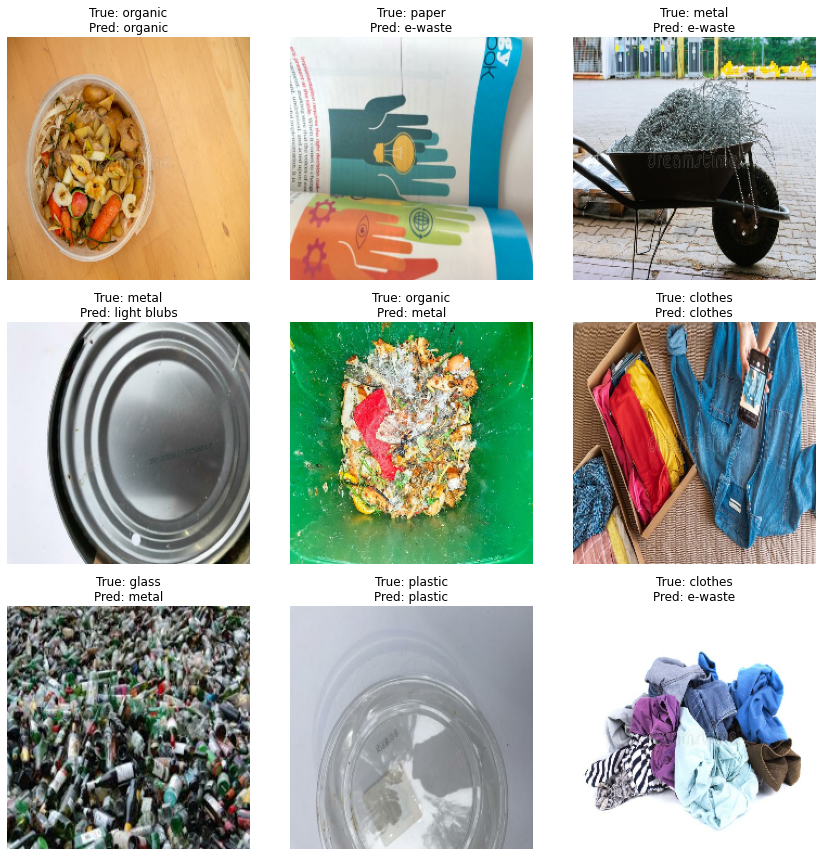

In [32]:
import matplotlib.pyplot as plt
import numpy as np

print("Predictions with Simple CNN:")

for images, labels in normalized_val_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

    plt.figure(figsize=(12, 12))
    for i in range(9):
        img = images[i]
        true_label = labels[i]

        img_expanded = np.expand_dims(img, axis=0)
        preds = simple_cnn.predict(img_expanded)
        pred_idx = np.argmax(preds, axis=1)[0]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Predictions with Deeper CNN:
1/1 [==============================] - 0s 102ms/step


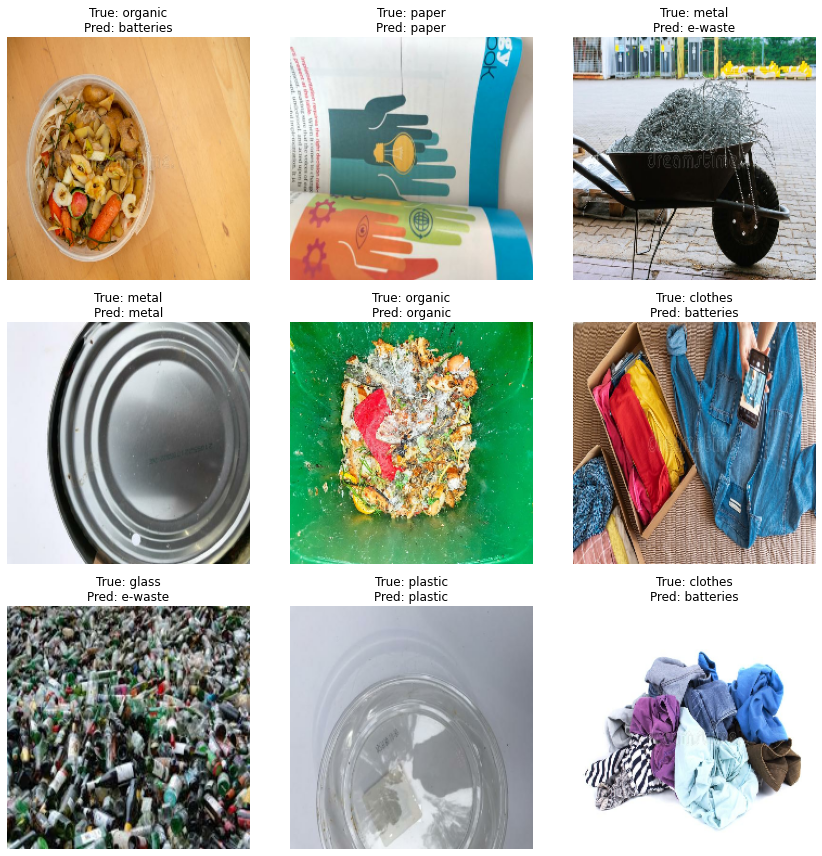

In [33]:
print("Predictions with Deeper CNN:")

for images, labels in normalized_val_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

    plt.figure(figsize=(12, 12))
    for i in range(9):
        img = images[i]
        true_label = labels[i]

        img_expanded = np.expand_dims(img, axis=0)
        preds = deeper_cnn.predict(img_expanded)
        pred_idx = np.argmax(preds, axis=1)[0]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


## try use transfer model

In [12]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model


In [49]:
base_model.output_shape

(None, 7, 7, 1280)

In [13]:
#build  full model
model = tf.keras.Sequential([
    base_model,
    # COVN2d
#     COVN2d
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')  
])

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
# train the model
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
209/209 [==============================] - 327s 1s/step - loss: 1.3883 - accuracy: 0.5328 - val_loss: 0.8958 - val_accuracy: 0.7200
Epoch 2/30
209/209 [==============================] - 277s 1s/step - loss: 0.9835 - accuracy: 0.6667 - val_loss: 0.7753 - val_accuracy: 0.7506
Epoch 3/30
209/209 [==============================] - 207s 990ms/step - loss: 0.8903 - accuracy: 0.7022 - val_loss: 0.7412 - val_accuracy: 0.7632
Epoch 4/30
209/209 [==============================] - 178s 850ms/step - loss: 0.8250 - accuracy: 0.7271 - val_loss: 0.8008 - val_accuracy: 0.7416
Epoch 5/30
209/209 [==============================] - 181s 866ms/step - loss: 0.7500 - accuracy: 0.7466 - val_loss: 0.6941 - val_accuracy: 0.7764
Epoch 6/30
209/209 [==============================] - 173s 829ms/step - loss: 0.7276 - accuracy: 0.7531 - val_loss: 0.6872 - val_accuracy: 0.7776
Epoch 7/30
209/209 [==============================] - 181s 866ms/step - loss: 0.7037 - accuracy: 0.7648 - val_loss: 0.6920 - val_a

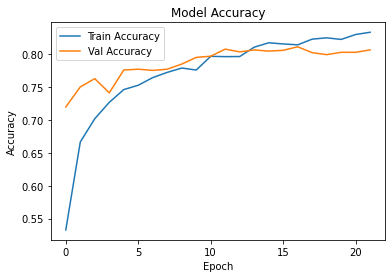

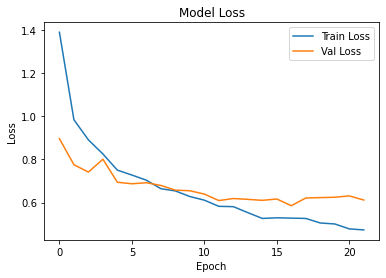

In [16]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [42]:
#save model
#model.save('transfer_model')

INFO:tensorflow:Assets written to: transfer_model\assets


INFO:tensorflow:Assets written to: transfer_model\assets


In [17]:
#save model
model.save('transfer_model.h5')

C:\Users\USER\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
#load
loaded_TL_model = keras.models.load_model('transfer_model.h5')

In [35]:
loss, acc = loaded_TL_model.evaluate(normalized_val_ds)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}")

53/53 [==============================] - 29s 542ms/step - loss: 0.5856 - accuracy: 0.8118
Validation Loss: 0.5856, Validation Accuracy: 0.8118


In [33]:
predictions = loaded_TL_model.predict(normalized_val_ds)
y_pred = [np.argmax(x) for x in predictions]

53/53 [==============================] - 32s 585ms/step


In [34]:
y_true = []
x_val = []

for images, labels in normalized_val_ds:
    x_val.append(images)
    y_true.extend(labels.numpy())  # Labels are class indices

x_val = np.concatenate(x_val)
y_true = np.array(y_true)

# Get predictions
predictions = loaded_TL_model.predict(normalized_val_ds)
y_pred = [np.argmax(x) for x in predictions]

# Convert to class names if needed
y_pred_labels = [class_names[i] for i in y_pred]
y_true_labels = [class_names[i] for i in y_true]


53/53 [==============================] - 30s 556ms/step


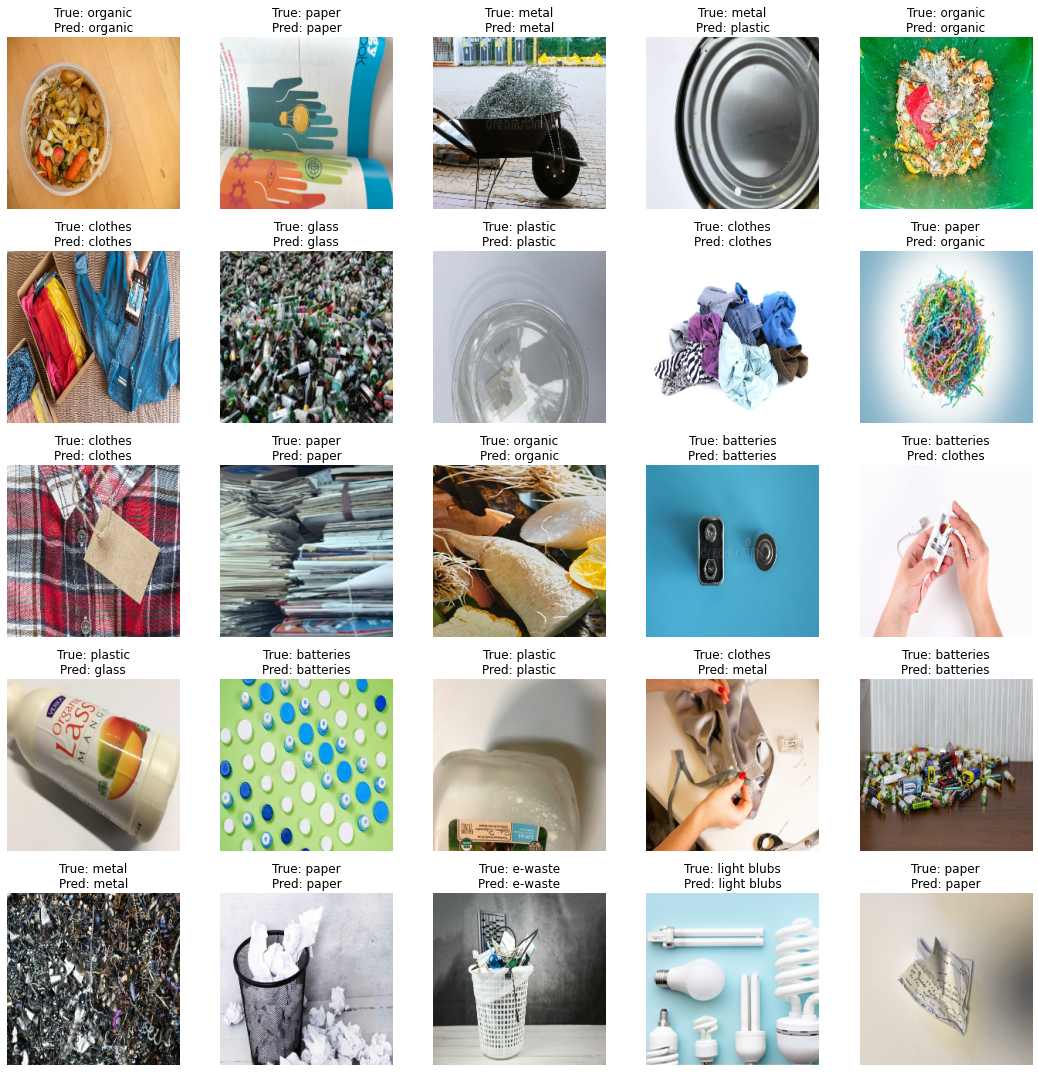

In [36]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i in range(25):
    img = x_val[i]

    # Normalize image for display if needed
    if img.max() > 1.0:
        img = img / 255.0

    axes[i].imshow(img)
    axes[i].set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Apply Fine-Tuning

In [23]:
#Unfreeze Part of Base Model
base_model.trainable = True  # Unfreeze the base model

# Freeze all layers except the last N layers
fine_tune_at = len(base_model.layers) - 20  

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',    
    metrics=['accuracy']
)


In [29]:
history_finetune = model.fit(
    normalized_train_ds,  #  training dataset
    epochs=10,  
    validation_data=normalized_val_ds
)


Epoch 1/10
209/209 [==============================] - 308s 1s/step - loss: 0.4956 - accuracy: 0.8283 - val_loss: 0.6075 - val_accuracy: 0.8177
Epoch 2/10
209/209 [==============================] - 304s 1s/step - loss: 0.4905 - accuracy: 0.8337 - val_loss: 0.6017 - val_accuracy: 0.8183
Epoch 3/10
209/209 [==============================] - 307s 1s/step - loss: 0.4689 - accuracy: 0.8396 - val_loss: 0.5994 - val_accuracy: 0.8219
Epoch 4/10
209/209 [==============================] - 343s 2s/step - loss: 0.4473 - accuracy: 0.8445 - val_loss: 0.5986 - val_accuracy: 0.8201
Epoch 5/10
209/209 [==============================] - 341s 2s/step - loss: 0.4491 - accuracy: 0.8445 - val_loss: 0.5921 - val_accuracy: 0.8237
Epoch 6/10
209/209 [==============================] - 287s 1s/step - loss: 0.4376 - accuracy: 0.8493 - val_loss: 0.5905 - val_accuracy: 0.8195
Epoch 7/10
209/209 [==============================] - 241s 1s/step - loss: 0.4139 - accuracy: 0.8574 - val_loss: 0.5889 - val_accuracy: 0.8237

In [66]:
#after fine tune TL model
model.save('fine_tuned_model.h5')

In [68]:
#from tensorflow.keras.models import load_model
model = load_model('fine_tuned_model.h5')

In [30]:
loss, acc = model.evaluate(normalized_val_ds)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}")


53/53 [==============================] - 37s 702ms/step - loss: 0.5762 - accuracy: 0.8267
Validation Loss: 0.5762, Validation Accuracy: 0.8267


Fine-tuning led to a slight improvement in performance.

Before fine-tuning:Validation Accuracy: 0.8118, Validation Loss: 0.5856

After fine-tuning: Validation Accuracy: 0.8267, Validation Loss: 0.5762

This shows that the base model already captured useful features, but fine-tuning helped the model adapt slightly better.

In [69]:
# Get predictions
predictions = model.predict(normalized_val_ds)
y_pred = [np.argmax(x) for x in predictions]

# Convert to class names
y_pred_labels = [class_names[i] for i in y_pred]

# Compare with true labels if stored
print(y_pred_labels[:10])  # Show first 10 predictions


53/53 [==============================] - 30s 553ms/step
['paper', 'paper', 'e-waste', 'metal', 'plastic', 'e-waste', 'plastic', 'glass', 'clothes', 'paper']


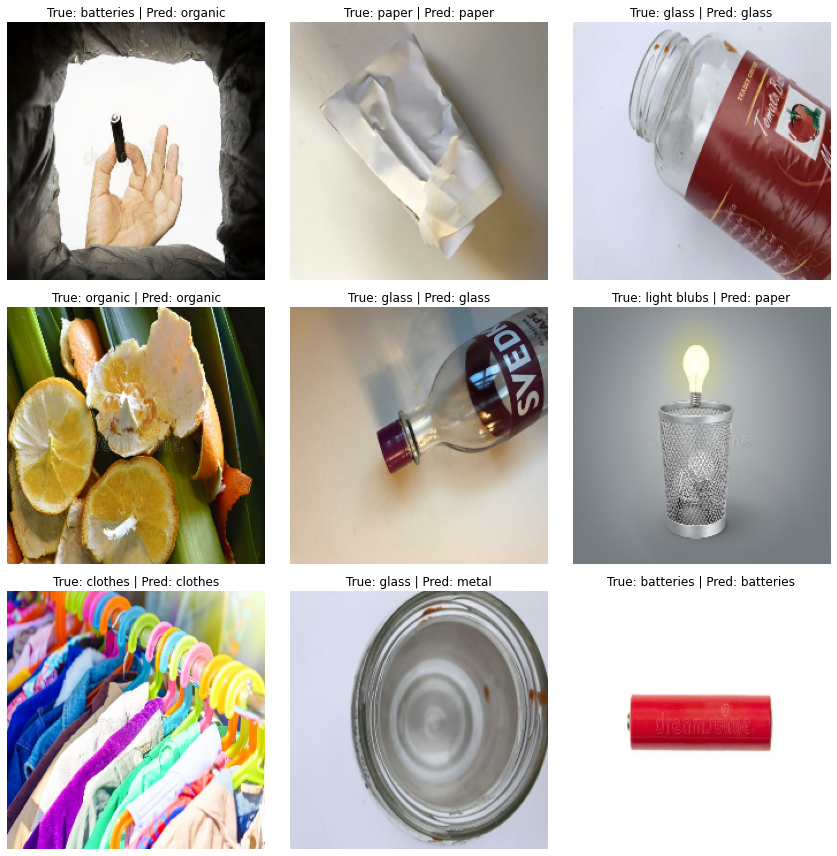

In [48]:
import random
import matplotlib.pyplot as plt

n = 9  
indices = random.sample(range(len(x_val)), n)  # pick n random indices without replacement

plt.figure(figsize=(12, 12))  # Adjust the figure size as needed

for i, idx in enumerate(indices):
    img = x_val[idx]
    if img.max() > 1.0:
        img = img / 255.0
    
    plt.subplot(3, 3, i + 1)  
    plt.imshow(img)
    plt.title(f"True: {y_true_labels[idx]} | Pred: {y_pred_labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


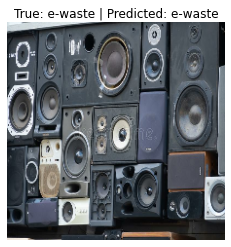

In [86]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(x_val) - 1)

img = x_val[idx]
if img.max() > 1.0:
    img = img / 255.0

plt.imshow(img)
plt.title(f"True: {y_true_labels[idx]} | Predicted: {y_pred_labels[idx]}")
plt.axis('off')
plt.show()
